In [151]:
# Imports and option settings

import altair as alt
import pandas as pd
import numpy as np
import os

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

alt.renderers.enable('notebook')
alt.data_transformers.enable('default', max_rows = None)

glovogreen = 'rgb(0,162,138)'
glovoyellow = 'rgb(252,224,93)'

My understanding of the task:


- Weeks worked by label, visualize and aggregate for training
- All features, univariate analysis by label
- Lifetime features by label
- Model
- Evaluation

In [39]:
# Define a few functions used later on in the notebook

def normalize_column(df, column):
    return (df[column] - min(df[column])) / (max(df[column]) - min(df[column]))

def get_perc(df, group, column):
    frequency = df.groupby(group).agg({column: 'value_counts'})
    frequency.columns = [column + '_frequency']
    frequency.reset_index(drop = False, inplace = True)
    
    sizes = df.groupby(group).size()
    
    frequency.loc[frequency[group] == 0, column + '_rel'] = frequency[column + '_frequency'] / sizes.loc[0]
    frequency.loc[frequency[group] == 1, column + '_rel'] = frequency[column + '_frequency'] / sizes.loc[1]
    
    return frequency

In [121]:
# Loading the data

files = os.listdir("/Users/julian/desktop/glovo")
csvs = [file for file in files if file.endswith(".csv")]

weekly = pd.read_csv(csvs[0])
lifetime = pd.read_csv(csvs[1])

In [122]:
# Creating the dataframe which will be the training input to the model later on

couriers = pd.DataFrame(columns = ["label"])

# Label every courier present in weekly data set based on whether data on week 9, 10 and 11 is present

for courier, data in weekly.groupby(["courier"]):
    weeks = list(data["week"])
    if 9 not in weeks and 10 not in weeks and 11 not in weeks:
        couriers.loc[courier, "label"] = 1
    else:
        couriers.loc[courier, "label"] = 0
        
# Eliminate any data from week 8 onward for training
weekly = weekly.loc[weekly.week.isin([0, 1, 2, 3, 4, 5, 6, 7])]

# Attach label to courier/week data for exploratory analysis
weekly = pd.merge(weekly, couriers, how = 'left', left_on = 'courier', right_index = True)

The weekly data set is about balanced in terms of absolute numbers of couriers labeled as 0 and 1

In [16]:
couriers.label.value_counts()

0.0    387
1.0    372
Name: label, dtype: int64

However, there are almost double as many entries for couriers labeled 0 in the weekly data set
suggesting they worked on average double as many days before week 8 compared to couriers labeled 1

We will look at this next

In [17]:
weekly.label.value_counts()

0.0    1969
1.0    1056
Name: label, dtype: int64

Clearly couriers labeled 1 work less weeks than couriers labeled 0 before week 8. This seems like a potential feature with predictive power for the model later

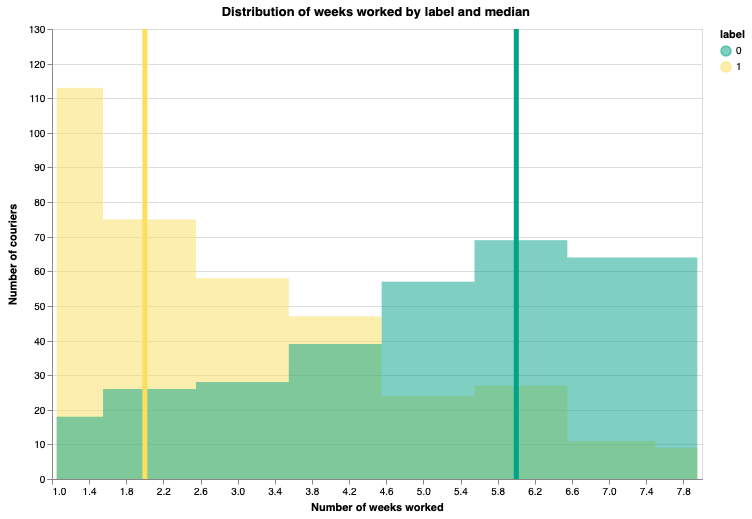

In [30]:
base = alt.Chart(weekly.groupby(['courier','label'], as_index = False).agg({'week': 'count'}))

bar = base.mark_area(
    opacity = 0.5,
    interpolate = 'step'
).encode(
    alt.X('week', title = 'Number of weeks worked', bin = alt.Bin(maxbins = 100)),
    alt.Y('count()', scale = alt.Scale(domain = (0,130)), title = 'Number of couriers', stack = None),
    alt.Color('label:N', scale = alt.Scale(range = [glovogreen, glovoyellow]))
).properties(width = 650, height = 450, title = 'Distribution of weeks worked by label and median')

rule = base.mark_rule().encode(
    x = alt.X('median(week):Q'),
    color = 'label:N',
    size = alt.value(5)
)

bar + rule

Next let's see whether univariate analysis on the individual features reveals any obvious discriminative power for courier churn

### Features 1 to 4

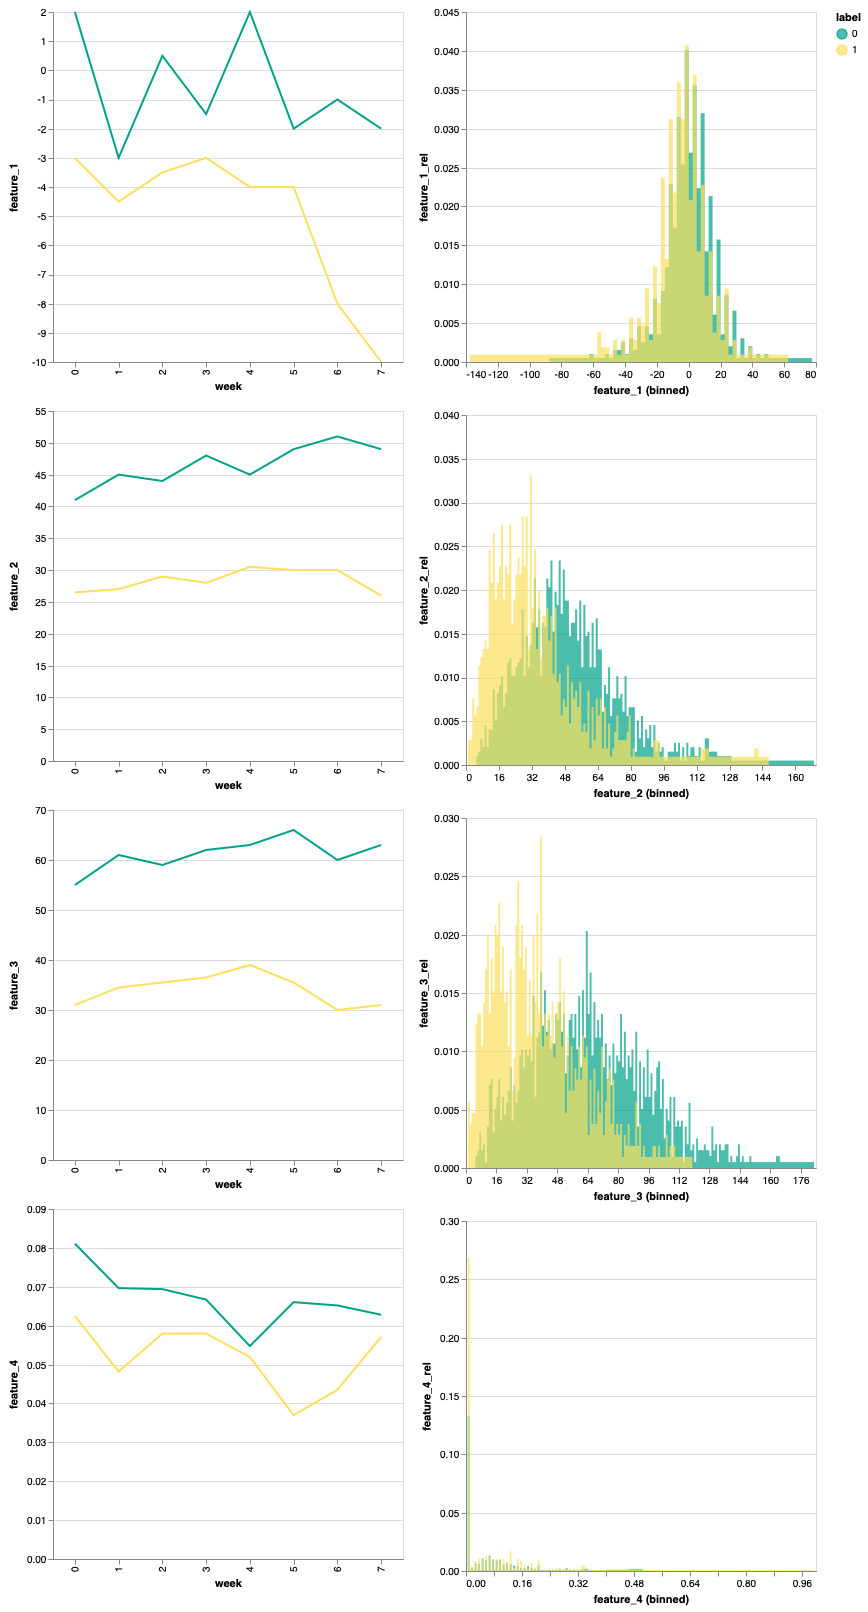

In [86]:
# Plot median feature values by week and label

features_to_plot = ['feature_1','feature_2', 'feature_3', 'feature_4']

x = alt.Chart(weekly.groupby(['week', 'label'], as_index = False).median()[['week','label'] + features_to_plot]
).mark_line().encode(
    alt.X(alt.repeat("column"), type = 'ordinal'),
    alt.Y(alt.repeat("row"), type = 'quantitative'),
    color = alt.Color('label:N', scale = alt.Scale(range = [glovogreen, glovoyellow]))
).properties(
    width = 350,
    height = 350
).repeat(
    row = features_to_plot,
    column = ['week']
)

# Plot relative frequencies of features by label

plots = []
for feature in features_to_plot:
    plots.append(
        alt.Chart(get_perc(weekly, 'label', feature)[[feature, feature + '_rel', 'label']]).mark_area(
            opacity = 0.7,
            interpolate = 'step'
        ).encode(
            alt.X(feature + ':Q', bin = alt.Bin(maxbins = 100)),
            alt.Y(feature + '_rel:Q'),
            alt.Color('label:N', scale = alt.Scale(range = [glovogreen, glovoyellow]))
        ).properties(height = 350, width = 350
        )
    )

v = alt.vconcat(plots[0],plots[1],plots[2],plots[3])
alt.hconcat(x, v)

### Features 5 to 8

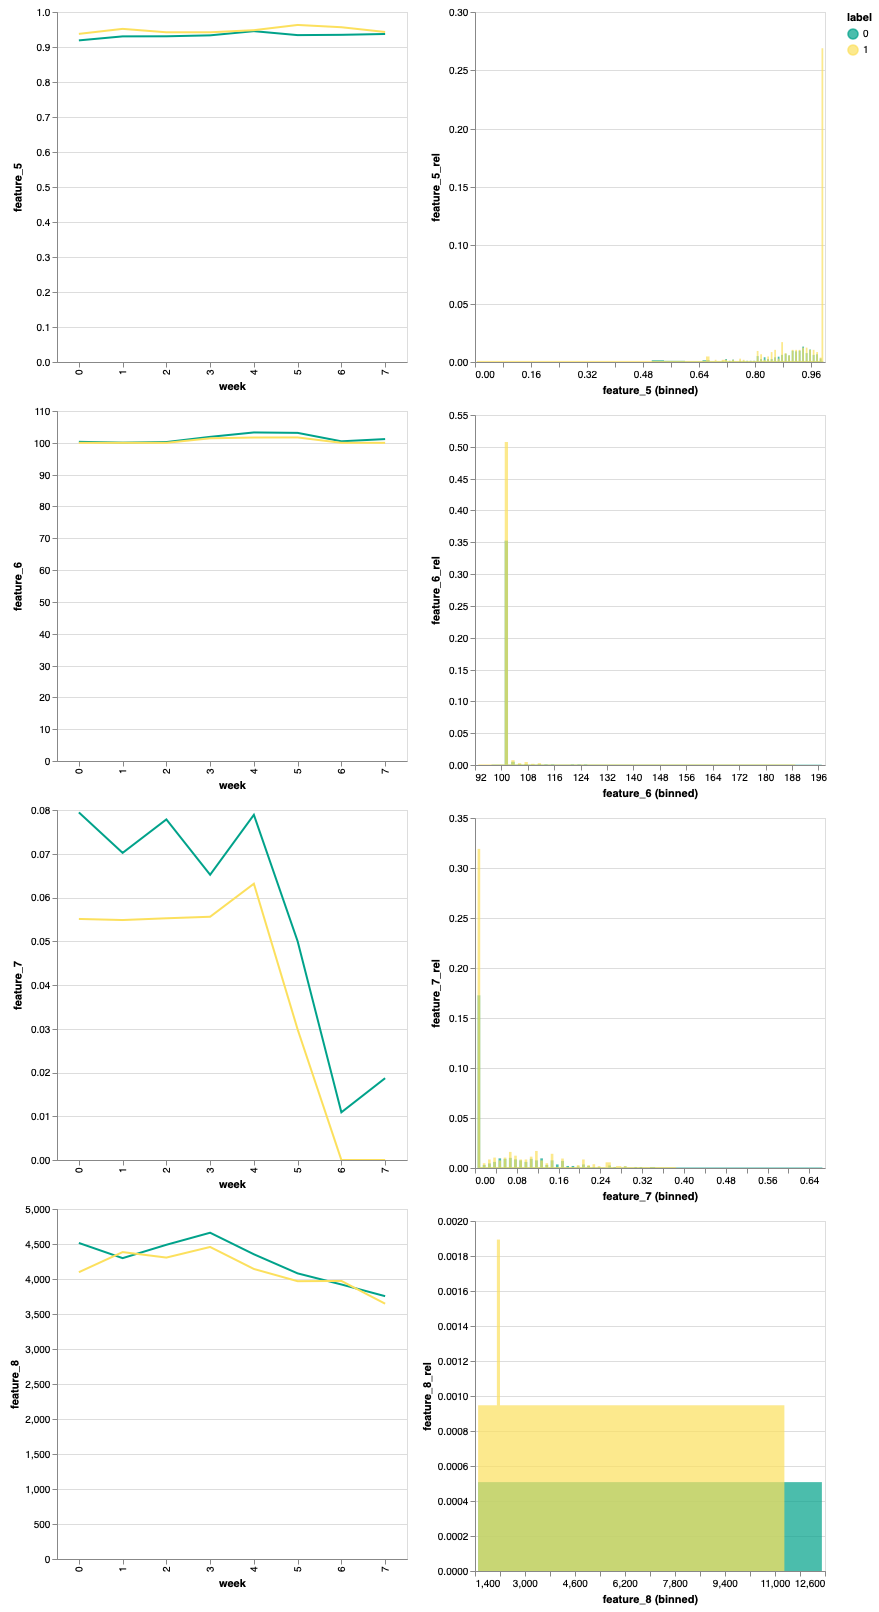

In [87]:
# Plot median feature values by week and label

features_to_plot = ['feature_5','feature_6', 'feature_7', 'feature_8']

x = alt.Chart(weekly.groupby(['week', 'label'], as_index = False).median()[['week','label'] + features_to_plot]
).mark_line().encode(
    alt.X(alt.repeat("column"), type = 'ordinal'),
    alt.Y(alt.repeat("row"), type = 'quantitative'),
    color = alt.Color('label:N', scale = alt.Scale(range = [glovogreen, glovoyellow]))
).properties(
    width = 350,
    height = 350
).repeat(
    row = features_to_plot,
    column = ['week']
)

# Plot relative frequencies of features by label

plots = []
for feature in features_to_plot:
    plots.append(
        alt.Chart(get_perc(weekly, 'label', feature)[[feature, feature + '_rel', 'label']]).mark_area(
            opacity = 0.7,
            interpolate = 'step'
        ).encode(
            alt.X(feature + ':Q', bin = alt.Bin(maxbins = 100)),
            alt.Y(feature + '_rel:Q'),
            alt.Color('label:N', scale = alt.Scale(range = [glovogreen, glovoyellow]))
        ).properties(height = 350, width = 350
        )
    )

v = alt.vconcat(plots[0],plots[1],plots[2],plots[3])
alt.hconcat(x, v)

### Features 9 to 12

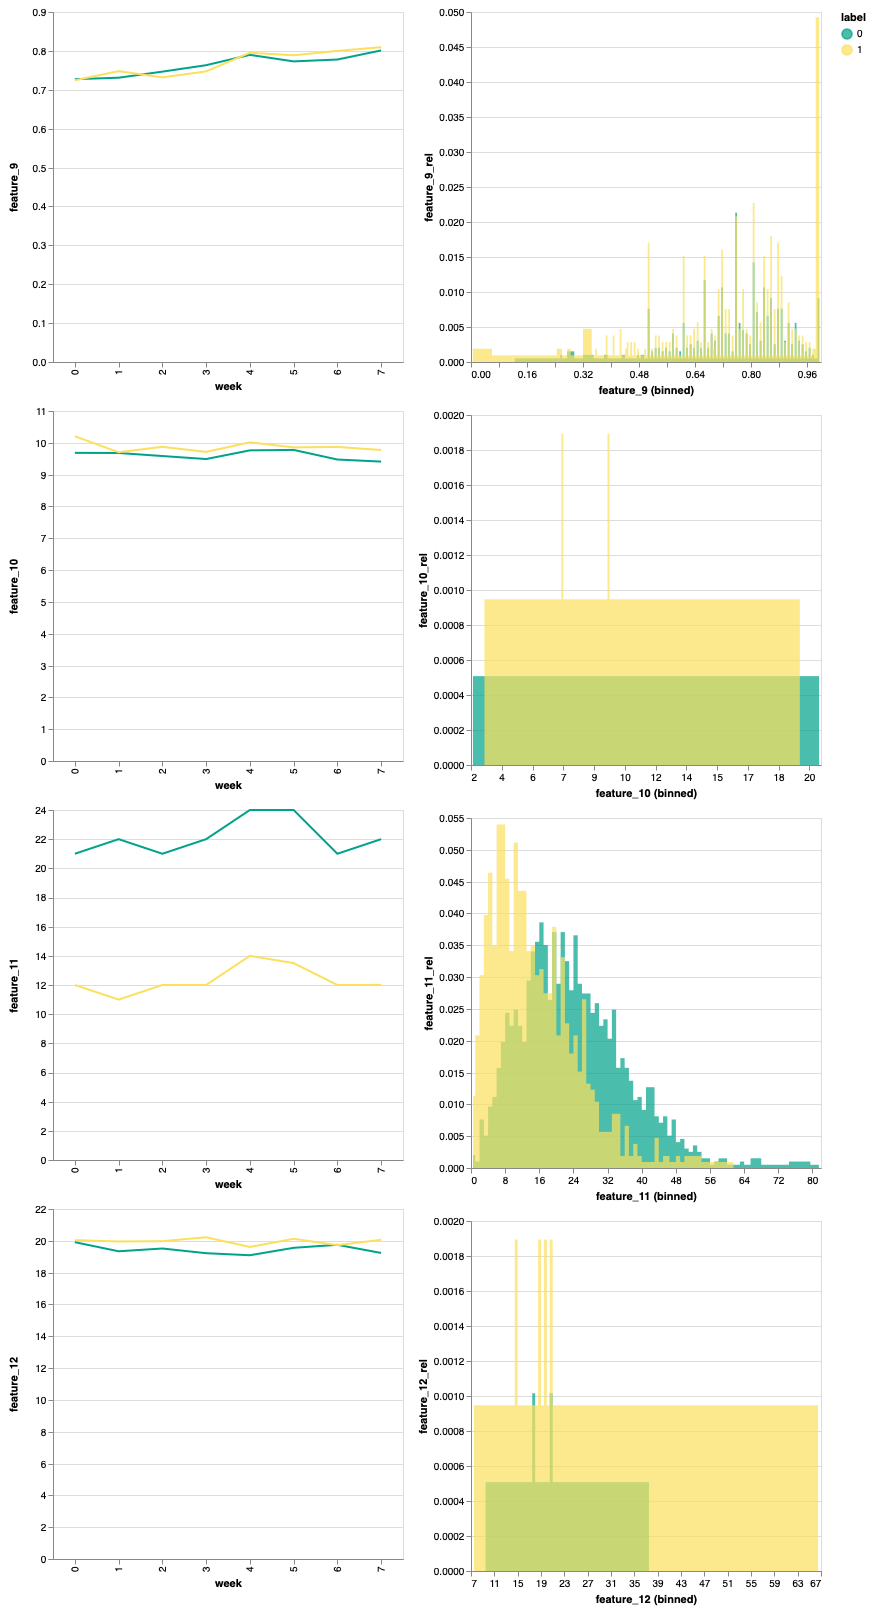

In [88]:
# Plot median feature values by week and label

features_to_plot = ['feature_9','feature_10', 'feature_11', 'feature_12']

x = alt.Chart(weekly.groupby(['week', 'label'], as_index = False).median()[['week','label'] + features_to_plot]
).mark_line().encode(
    alt.X(alt.repeat("column"), type = 'ordinal'),
    alt.Y(alt.repeat("row"), type = 'quantitative'),
    color = alt.Color('label:N', scale = alt.Scale(range = [glovogreen, glovoyellow]))
).properties(
    width = 350,
    height = 350
).repeat(
    row = features_to_plot,
    column = ['week']
)

# Plot relative frequencies of features by label

plots = []
for feature in features_to_plot:
    plots.append(
        alt.Chart(get_perc(weekly, 'label', feature)[[feature, feature + '_rel', 'label']]).mark_area(
            opacity = 0.7,
            interpolate = 'step'
        ).encode(
            alt.X(feature + ':Q', bin = alt.Bin(maxbins = 100)),
            alt.Y(feature + '_rel:Q'),
            alt.Color('label:N', scale = alt.Scale(range = [glovogreen, glovoyellow]))
        ).properties(height = 350, width = 350
        )
    )

v = alt.vconcat(plots[0],plots[1],plots[2],plots[3])
alt.hconcat(x, v)

### Feature 13 to 17

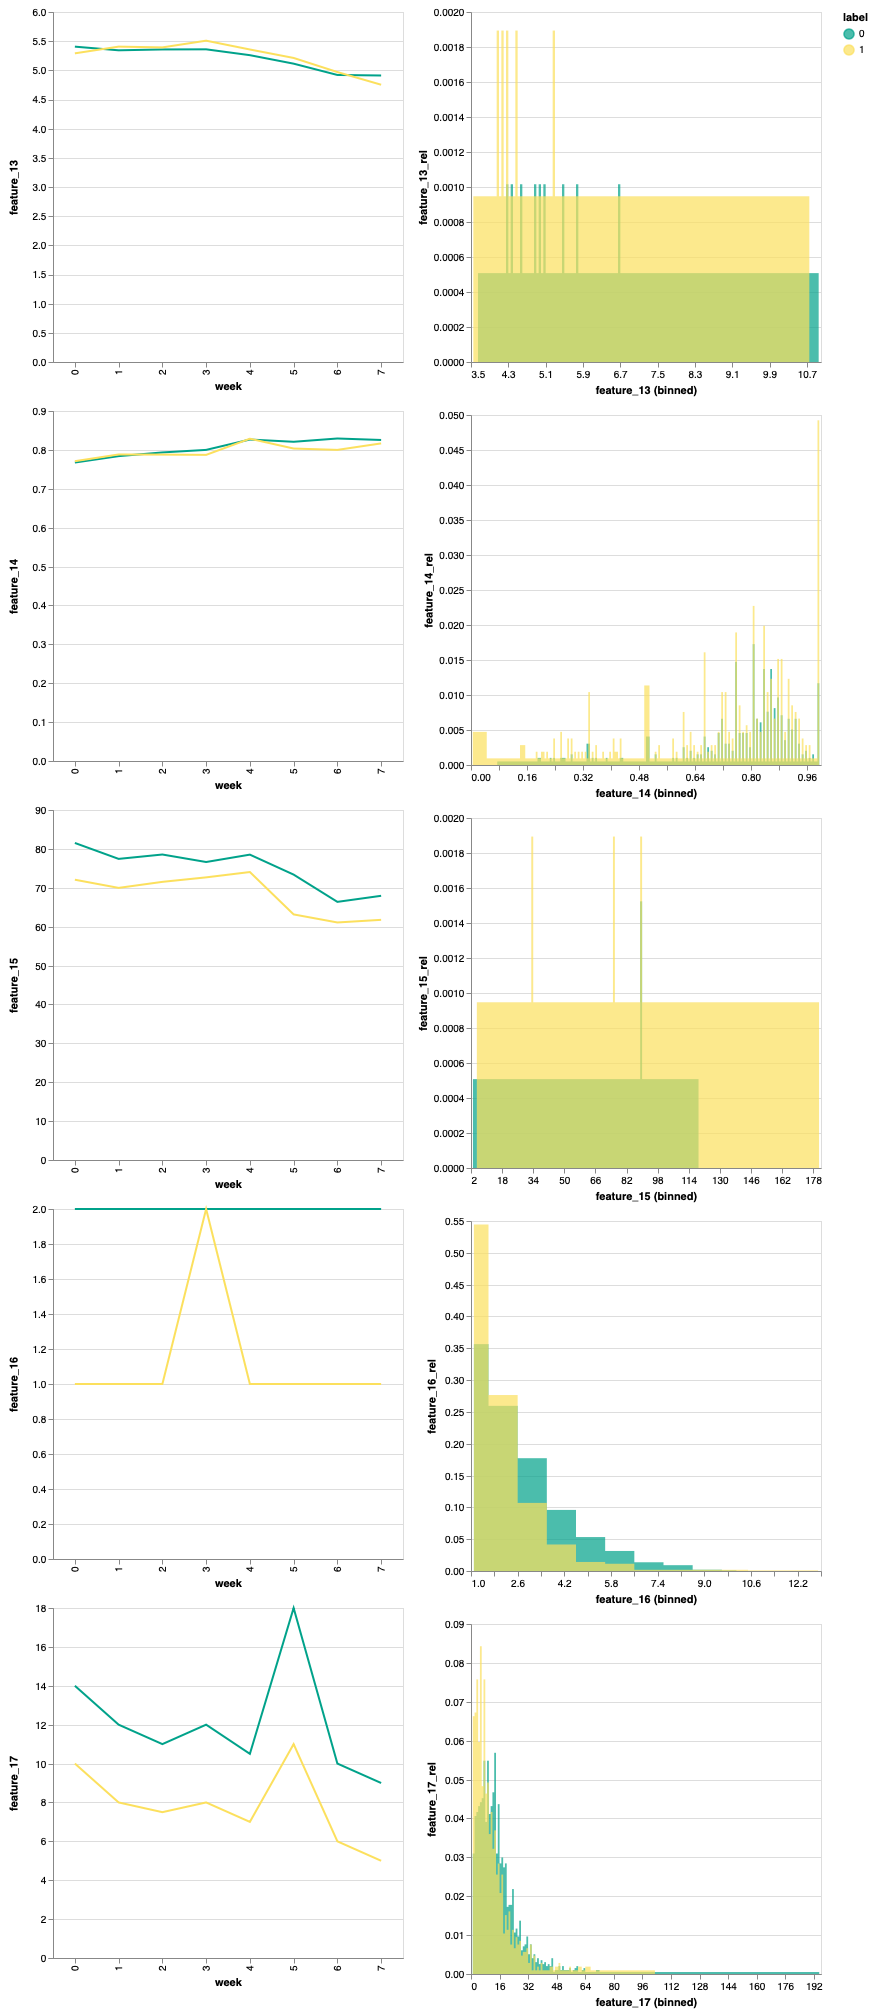

In [91]:
# Plot median feature values by week and label

features_to_plot = ['feature_13','feature_14', 'feature_15', 'feature_16', 'feature_17']

x = alt.Chart(weekly.groupby(['week', 'label'], as_index = False).median()[['week','label'] + features_to_plot]
).mark_line().encode(
    alt.X(alt.repeat("column"), type = 'ordinal'),
    alt.Y(alt.repeat("row"), type = 'quantitative'),
    color = alt.Color('label:N', scale = alt.Scale(range = [glovogreen, glovoyellow]))
).properties(
    width = 350,
    height = 350
).repeat(
    row = features_to_plot,
    column = ['week']
)

# Plot relative frequencies of features by label

plots = []
for feature in features_to_plot:
    plots.append(
        alt.Chart(get_perc(weekly, 'label', feature)[[feature, feature + '_rel', 'label']]).mark_area(
            opacity = 0.7,
            interpolate = 'step'
        ).encode(
            alt.X(feature + ':Q', bin = alt.Bin(maxbins = 100)),
            alt.Y(feature + '_rel:Q'),
            alt.Color('label:N', scale = alt.Scale(range = [glovogreen, glovoyellow]))
        ).properties(height = 350, width = 350
        )
    )

v = alt.vconcat(plots[0],plots[1],plots[2],plots[3], plots[4])
alt.hconcat(x, v)

In [10]:
weekly_norm = weekly_training.loc[:, ['courier','week']]

In [11]:
for column in weekly_training.columns[2:]:
    weekly_norm.loc[:, column] = normalize_column(weekly_training, column)

In [12]:
# Add columns for averages in first 3 weeks and following 4 weeks to couriers dataframe

start_columns = {key + '_startavg': 0 for key in weekly_norm.columns[2:]}
end_columns = {key + '_endavg': 0 for key in weekly_norm.columns[2:]}
all_columns = {**start_columns, **end_columns}
couriers = couriers.assign(**all_columns)

In [13]:
# Compute averages from week 1-3 and week 4 - 7 for every courier

for courier, data in weekly_norm.groupby(['courier']):
    start = data.loc[data.week <= 3]
    end = data.loc[data.week >= 4]
    
    avg_start = start.drop(['courier', 'week'], axis = 1).mean()
    avg_end = end.drop(['courier', 'week'], axis = 1).mean()
    
    couriers.loc[courier, list(avg_start.index + '_startavg')] = avg_start.values
    couriers.loc[courier, list(avg_end.index + '_endavg')] = avg_end.values

In [14]:
courier_averages = pd.DataFrame(index = list(range(68)), columns = ['label','feature','week','average'])

In [15]:
# Prepare data frame for plotting averages in first 3 weeks vs remaining weeks for couriers labeled 1 and 0
# This is getting a little messy

for label, data in couriers.groupby('label'):
    if label == 0:
        courier_averages.loc[0:33, 'label'] = 0
        courier_averages.loc[0:16, 'feature'] = [element + 1 for element in range(17)]
        courier_averages.loc[17:33, 'feature'] = [element + 1 for element in range(17)]
        courier_averages.loc[0:16, 'week'] = 'before'
        courier_averages.loc[17:33, 'week'] = 'after'
        courier_averages.loc[0:33, 'average'] = data.agg('mean').values[1:]
    elif label == 1:
        courier_averages.loc[34:67, 'label'] = 1
        courier_averages.loc[34:50, 'feature'] = [element + 1 for element in range(17)]
        courier_averages.loc[51:67, 'feature'] = [element + 1 for element in range(17)]
        courier_averages.loc[34:50, 'week'] = 'before'
        courier_averages.loc[51:67, 'week'] = 'after'
        courier_averages.loc[34:67, 'average'] = data.agg('mean').values[1:]

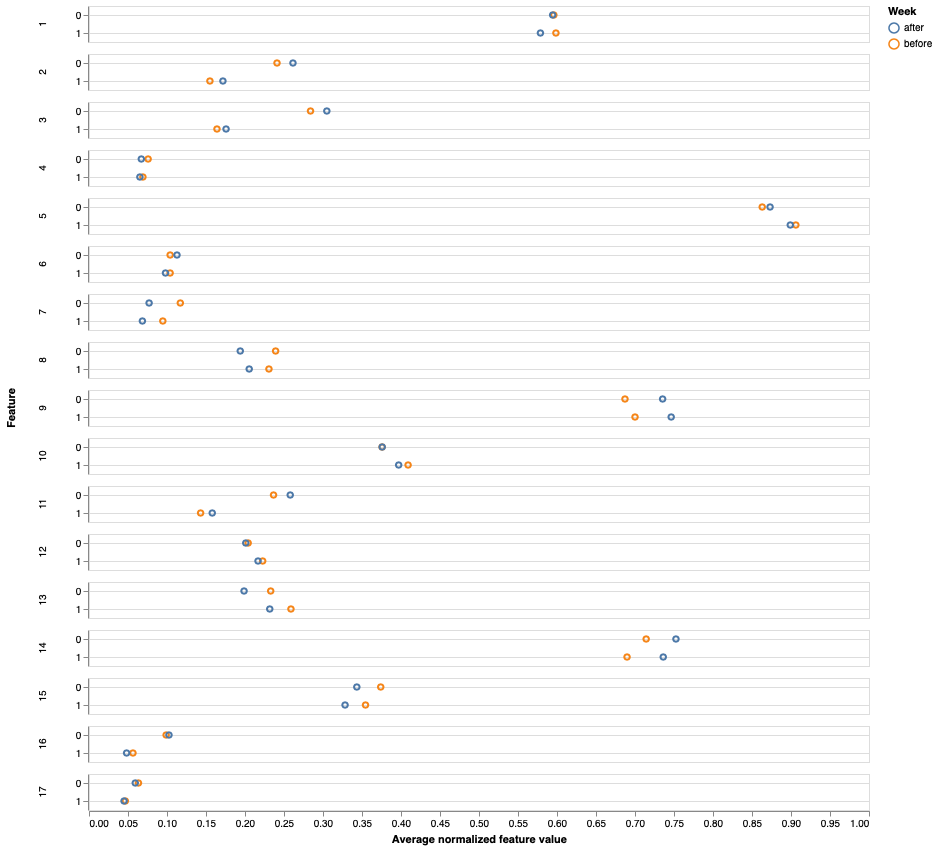

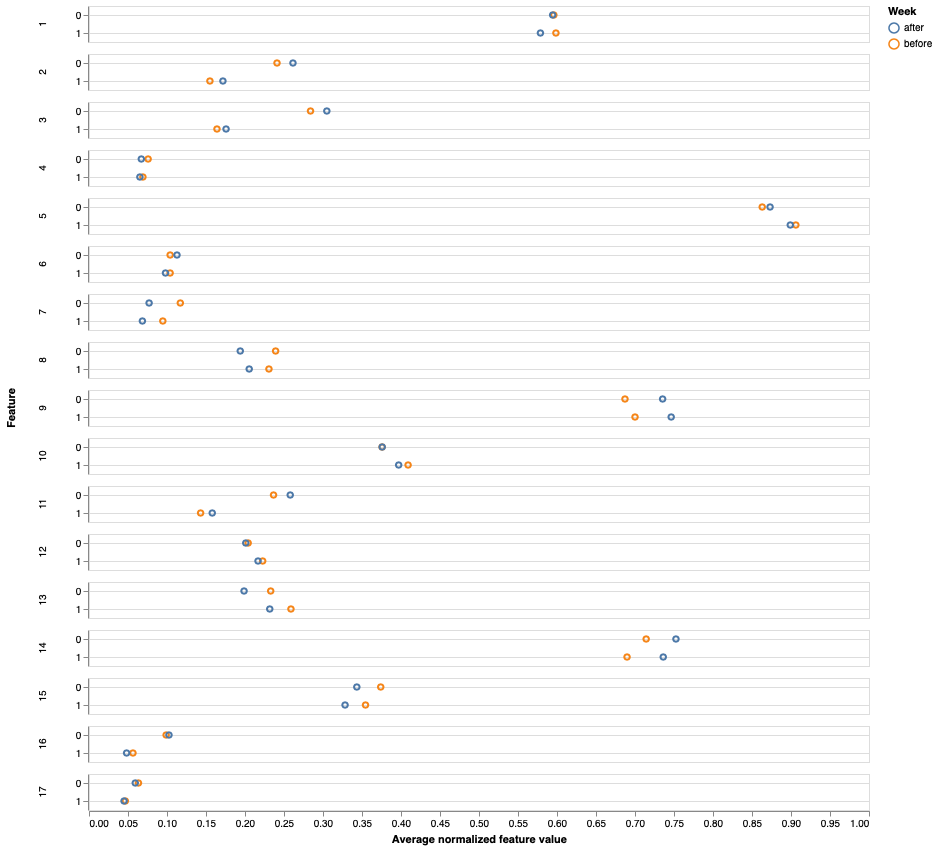

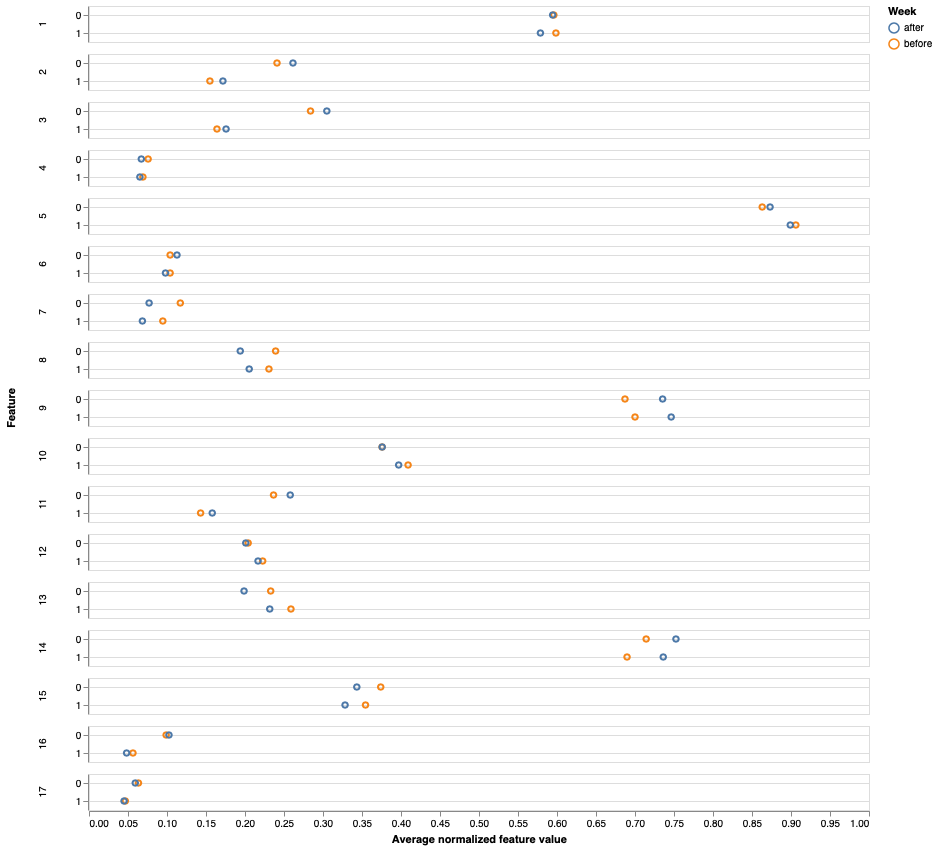

In [34]:
alt.Chart(courier_averages).mark_point(opacity = 1, shape = '', thickness = 0.19, color = glovogreen).encode(
    alt.X(
        'average:Q',
        scale = alt.Scale(zero = False),
        axis = alt.Axis(grid = False, title = "Average normalized feature value")
    ),
    alt.Y(
        'label:N',
        sort = alt.EncodingSortField(field = 'average', op = 'sum', order = 'descending'),
        scale = alt.Scale(rangeStep = 18),
        axis = alt.Axis(title = "", grid = True)
    ),
    color = alt.Color('week:N', legend = alt.Legend(title = "Week")),
    row = alt.Row('feature:N', title = "Feature")
).properties(width = 780)

In [130]:
weekly_training = pd.merge(weekly_training, pd.DataFrame(couriers.loc[:,'label']), how = 'left', left_on = 'courier', right_index = True)

In [62]:
weekly_training.columns[2:-1]

Index(['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10',
       'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17'],
      dtype='object')

In [70]:
averages

,week,label,courier,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17
0,0,0.0,359176.357143,1.315126,45.260504,58.827731,0.090482,0.909519,106.053766,0.085295,4437.723468,0.708934,9.876620,21.747899,20.258574,5.467387,0.742684,76.254244,2.403361,17.394958
1,0,1.0,385386.988506,-4.114943,31.206897,35.488506,0.075967,0.924035,105.018178,0.064919,4072.880405,0.709594,10.297637,13.528736,20.533450,5.447871,0.709309,69.615762,1.683908,12.643678
2,1,0.0,360754.432000,-5.032000,48.464000,63.060000,0.079010,0.920991,104.126097,0.075507,4181.308568,0.720924,9.775528,23.212000,19.741850,5.254216,0.760420,74.533992,2.428000,14.052000
3,1,1.0,379419.910714,-5.547619,32.220238,37.083333,0.066339,0.933662,104.113175,0.068415,4228.893433,0.730273,9.807815,13.797619,20.453012,5.463565,0.736501,67.924930,1.880952,10.244048
4,2,0.0,365425.528000,1.088000,46.096000,60.012000,0.086174,0.913826,103.874120,0.087534,4317.939870,0.727227,9.659226,21.740000,19.932237,5.318375,0.764724,75.128956,2.496000,13.480000
5,2,1.0,383766.294521,-3.979452,33.267123,38.534247,0.082933,0.917067,103.412775,0.075227,4147.130616,0.715450,10.016378,14.267123,20.190787,5.453256,0.719877,68.909040,1.712329,10.369863
6,3,0.0,360185.512000,-1.832000,49.524000,62.744000,0.077243,0.922758,104.380617,0.084175,4436.260151,0.753972,9.631119,22.896000,19.723126,5.371099,0.778491,73.014563,2.376000,14.912000
7,3,1.0,384869.487500,-6.243750,32.187500,38.487500,0.078648,0.921353,103.862461,0.061744,4358.304741,0.722589,9.689145,14.393750,20.566301,5.608189,0.707259,70.363892,2.000000,12.168750
8,4,0.0,364815.527778,1.388889,47.519841,65.003968,0.070925,0.929076,106.360401,0.101895,4095.469952,0.781447,9.974659,24.718254,19.537492,5.278512,0.797932,76.362398,2.376984,12.500000
9,4,1.0,380361.194030,-5.492537,33.716418,40.746269,0.068526,0.931476,104.511495,0.086301,4095.761294,0.759426,10.201164,15.791045,20.181279,5.467668,0.766763,71.592910,1.828358,10.500000


In [ ]:
We identified a few features that seem promising. Now they are computed and added to the training input

In [123]:
# Attach feature 'weeks_worked' to couriers dataframe

couriers = pd.merge(couriers, 
                    weekly.groupby(['courier','label'], as_index = False).agg({'week': 'count'})[['courier','week']],
                    how = 'left', left_index = True, right_on = 'courier')

couriers.columns = ['label','courier','weeks_worked']

# There are some couriers that have a missing value for weeks_worked after this merge
# We will in 0 for the 'weeks_worked' feature for these couriers as these are couriers who have weekly
# entries only for weeks greater than 7

couriers.loc[couriers.weeks_worked.isnull(), 'weeks_worked'] = 0

The data set is balanced. There are a few more couriers labeled 0 (51%). Thus, 51% accuracy could be achieved by random guessing. This is the minimum baseline any useful model should beat.

In [124]:
# Percentage of couriers labeled 0, this will be used the base evaluation line
couriers.label.value_counts()[0] / (couriers.label.value_counts()[0] + couriers.label.value_counts()[1])

0.5098814229249012

In [149]:
skf = StratifiedKFold(n_splits = 3, shuffle = True)

In [165]:
labels = np.array(couriers.loc[:,'label'])
training = np.array(couriers.loc[:,'weeks_worked']).reshape(-1,1)

skf = StratifiedKFold(n_splits = 3, shuffle = True)

p_grid = {
          "penalty": ['l1','l2'],
          "solver": ['lbfgs', 'liblinear', 'sag', 'saga'],
          "multi_class": ['auto']
         }

lr = LogisticRegression(random_state = 69, 
                         solver = 'lbfgs', 
                         multi_class = 'auto')


cv = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 69)


clf = GridSearchCV(estimator = lr, param_grid = p_grid, cv = cv, error_score = 0.0)
clf.fit(training, labels) 

score = cross_val_score(clf, X = training, y = labels, cv = cv)

print('Model performance: ', score)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:559: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: Solver lbfgs supports only l2 penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:559: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: Solver sag supports only l2 penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:559: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: Solver lbfgs supports only l2 penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:

Model performance:  [0.71578947 0.73684211 0.68421053 0.74603175]


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:559: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: Solver lbfgs supports only l2 penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:559: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: Solver sag supports only l2 penalties, got l1 penalty.

  FitFailedWarning)


In [166]:
clf.best_params_

{'multi_class': 'auto', 'penalty': 'l1', 'solver': 'liblinear'}

In [167]:
clf.score(training, labels)

0.7206851119894598